# Evaluasi Multi Label

In [58]:
import os
import glob
import os
from os import listdir
from PIL import Image
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
import numpy as np

import pickle
import cv2
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine

# Defining the path to the directory with the dataset
data_dir = 'dataset/'

# Defining the path to the directory with the training and testing dataset
train_dir = 'train/'
test_dir = 'test/'

# Defining the percentage of data to use for training (70%)
train_percentage = 0.8

# Loop through each label directory in the data directory
for label_dir in os.listdir(data_dir):
    # Get the path to the label directory
    label_path = os.path.join(data_dir, label_dir)

    # Get a list of all the image filenames in the label directory
    image_filenames = os.listdir(label_path)

    # Shuffle the list of image filenames
    random.shuffle(image_filenames)

    # Calculate the number of images to use for training and testing
    num_images = len(image_filenames)
    num_train_images = int(num_images * train_percentage)
    num_test_images = num_images - num_train_images

    # Split the image filenames into training and testing sets
    train_image_filenames = image_filenames[:num_train_images]
    test_image_filenames = image_filenames[num_train_images:]

    # Create the label directory in the train and test directories if they don't exist yet
    if not os.path.exists(os.path.join(train_dir, label_dir)):
        os.makedirs(os.path.join(train_dir, label_dir))
    if not os.path.exists(os.path.join(test_dir, label_dir)):
        os.makedirs(os.path.join(test_dir, label_dir))

    # Copy the training images to the train directory
    for filename in train_image_filenames:
        src_path = os.path.join(label_path, filename)
        dst_path = os.path.join(train_dir, label_dir, filename)
        shutil.copy(src_path, dst_path)

    # Copy the testing images to the test directory
    for filename in test_image_filenames:
        src_path = os.path.join(label_path, filename)
        dst_path = os.path.join(test_dir, label_dir, filename)
        shutil.copy(src_path, dst_path)


In [59]:
import os
import cv2
import numpy as np
from keras_facenet import FaceNet

# Load FaceNet model
model = FaceNet()

# load cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define a function to extract embeddings from an image
def get_embedding(img_path, model):
    # Read image
    img = cv2.imread(img_path)
    
    # Detect faces
    wajah = face_cascade.detectMultiScale(img, 1.1, 4)

    # If no face is detected, skip to next image
    if len(wajah) == 0:
        return None

    # Extract face region
    x1, y1, width, height = wajah[0]
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    img = img[y1:y2, x1:x2]
    
    # Convert image to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image to (160, 160)
    img = cv2.resize(img, (224, 224))
    
    # Convert image to tensor
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    
    # Embed face using model
    embedding = model.embeddings(img)[0, :]
    
    return embedding

## Embedding Data Train

In [207]:
import os
import glob

# dataset
root_dir = 'train'

# get list of image file paths and labels
image_paths = []
labels = []
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            image_paths.append(os.path.join(subdir, file))
            labels.append(os.path.basename(subdir))



In [208]:
# Iterate through all images in image_paths
embeddings = []
for img_path in image_paths:
    # Extract embedding from image and append to list
    embedding = get_embedding(img_path, model)
    
    # Check if embedding is None
    if embedding is None:
        continue
        
    embeddings.append(embedding)

1/1 [==============================] - 0s 88ms/step


In [209]:
label_dict = {}
for label, embedding in zip(labels, embeddings):
    if label not in label_dict:
        label_dict[label] = []
    label_dict[label].append(embedding)

In [210]:
def is_match(known_embedding, label_dict = label_dict, threshold = 0.4):
    label_match = []
    score_match = []
    
    label_true = []
    score_true = []

    for label, embeddings_list in label_dict.items():
        for i, embedding in enumerate(embeddings_list):
            if len(embedding) == 0:
                continue
                
            scores = cosine(known_embedding, embedding)
            label_match.append(label)
            score_match.append(scores)

    if score_match:
        min_index = np.argmin(score_match)
        label = label_match[min_index]
        score = score_match[min_index]
        if score <= threshold:
            label_data = label
            label_true.append(label)
            score_true.append(score)
        else:
            label_data = 'Kamu siapa?'
    else:
        label_data = 'Tidak terdeteksi'

    return label_data, label, score

## Embedding Data Test

In [211]:
import os
import glob

test_data_dir = "test" # ganti dengan path ke direktori test data
test_data = []

for subdir in os.listdir(test_data_dir):
    subdir_path = os.path.join(test_data_dir, subdir)
    if os.path.isdir(subdir_path):
        for image_path in glob.glob(os.path.join(subdir_path, "*.jpg")):
            label = subdir
            test_data.append((image_path, label))


In [212]:
test_embeddings = []
for image, label in test_data:
    embedding = get_embedding(image, model)
    # Check if embedding is None
    if embedding is None:
        continue
    test_embeddings.append((embedding, label))

1/1 [==============================] - 0s 71ms/step


## Threshold Tuning

In [213]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# list of possible thresholds
thresholds = np.arange(0, 1.1, 0.1)

# initialize variables to store the best threshold and accuracy
best_threshold = 0
best_accuracy = 0

list_thresh = []
list_acc = []

# Buat daftar kosong untuk menyimpan skor performa pada setiap nilai threshold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# loop through each threshold
for threshold in thresholds:
    # initialize variables to store the true and predicted labels
    y_true = []
    y_pred = []

    # loop through each test image
    for image, label in test_embeddings:
        # get the predicted label and score for the image
        label_pred, _, score = is_match(image, threshold=threshold)

        # add the true and predicted labels to the respective lists
        y_true.append(label)
        y_pred.append(label_pred)

    # calculate the accuracy score for this threshold
    accuracy = accuracy_score(y_true, y_pred)
    
    list_thresh.append(threshold)
    list_acc.append(accuracy)
    
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    recall_scores.append(recall_score(y_true, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, average='macro', zero_division=0))

    # update the best threshold and accuracy if the current accuracy is higher
    if accuracy > best_accuracy:
        best_threshold = threshold
        best_accuracy = accuracy

# print the best threshold and accuracy
print("Best threshold:", best_threshold)
print("Best accuracy:", best_accuracy)
print()
print('Threshold')
print(list_thresh)
print('Accuracy')
print(list_acc)
print()
print('Label Benar')
print(y_true)
print('Label Prediksi')
print(y_pred)

Best threshold: 0.30000000000000004
Best accuracy: 0.9090909090909091

Threshold
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
Accuracy
[0.0, 0.5454545454545454, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091]

Label Benar
['Ainun', 'Ainun', 'andhar', 'andhar', 'eyang_kunah', 'eyang_kunah', 'eyang_kunah', 'eyang_kunah', 'Tika', 'Tika', 'Tika']
Label Prediksi
['Ainun', 'Ainun', 'andhar', 'andhar', 'eyang_kunah', 'eyang_kunah', 'eyang_kunah', 'Ainun', 'Tika', 'Tika', 'Tika']


## Accuracy, Precision, Recall & F1 score

In [214]:
# Cetak skor performa pada setiap nilai threshold
print("Accuracy scores:", accuracy_scores)
print("Precision scores:", precision_scores)
print("Recall scores:", recall_scores)
print("F1 scores:", f1_scores)

Accuracy scores: [0.0, 0.5454545454545454, 0.7272727272727273, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091]
Precision scores: [0.0, 0.6, 0.8, 0.8, 0.8, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666]
Recall scores: [0.0, 0.3833333333333333, 0.5833333333333333, 0.75, 0.75, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 0.9375]
F1 scores: [0.0, 0.4647619047619048, 0.6647619047619048, 0.7714285714285715, 0.7714285714285715, 0.9142857142857143, 0.9142857142857143, 0.9142857142857143, 0.9142857142857143, 0.9142857142857143, 0.9142857142857143]


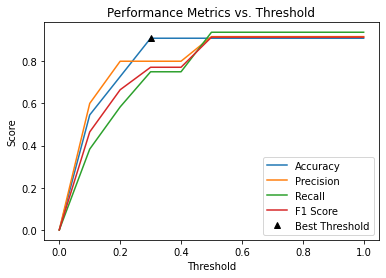

Optimal threshold: 0.30000000000000004
Accuracy: 0.9090909090909091
Precision: 0.8
Recall: 0.75
F1 Score: 0.7714285714285715


In [215]:
# Plot grafik kurva performa pada berbagai nilai threshold
import matplotlib.pyplot as plt

# Contoh: Pilih nilai threshold dengan akurasi tertinggi
optimal_threshold = thresholds[np.argmax(accuracy_scores)]

# Cari indeks nilai threshold pada array numpy
index = np.where(thresholds == optimal_threshold)[0][0]

# Ambil nilai akurasi, presisi, recall, dan F1 score pada indeks yang sesuai
accuracy = accuracy_scores[index]
precision = precision_scores[index]
recall = recall_scores[index]
f1_score = f1_scores[index]

plt.plot(thresholds, accuracy_scores, label="Accuracy")
plt.plot(thresholds, precision_scores, label="Precision")
plt.plot(thresholds, recall_scores, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.plot(optimal_threshold,accuracy,'k^', label='Best Threshold') 
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs. Threshold")
plt.show()

print("Optimal threshold:", optimal_threshold)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

## ROC Curve

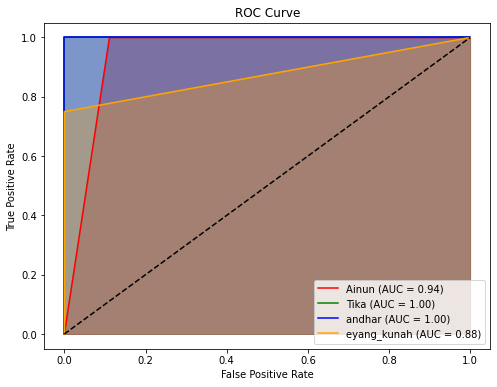

AUC untuk Ainun: 0.94
AUC untuk Tika: 1.00
AUC untuk andhar: 1.00
AUC untuk eyang_kunah: 0.88
Rata-rata AUC: 0.95


In [222]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Membuat daftar label unik
labels_unique = list(set(y_true+y_pred))
labels_unique.sort() # Mengurutkan label

# Menetapkan kembali nilai label agar sesuai dengan urutan unik
y_true_num = np.array([labels_unique.index(label) for label in y_true])
y_pred_num = np.array([labels_unique.index(label) for label in y_pred])

# Menghitung nilai AUC untuk setiap label
n_classes = len(labels_unique)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true_num == i).astype(int), (y_pred_num == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = ['red', 'green', 'blue', 'orange']
    
# Membuat plot ROC untuk setiap label
plt.figure(figsize=(8,6))
for i in range(n_classes):
    line, = plt.plot(fpr[i], tpr[i], label="{} (AUC = {:.2f})".format(labels_unique[i], roc_auc[i]), color=colors[i])
    plt.fill_between(fpr[i], tpr[i], 0, alpha=0.3, color=line.get_color())

# Mengatur parameter plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Menampilkan plot
plt.show()

# Menampilkan hasil
for i in range(n_classes):
    print("AUC untuk {}: {:.2f}".format(labels_unique[i], roc_auc[i]))

print("Rata-rata AUC: {:.2f}".format(np.mean(list(roc_auc.values()))))


# Evaluasi Single Label

In [3]:
import os
import glob
import os
import random
import shutil
from os import listdir
from PIL import Image
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
import numpy as np

import pickle
import cv2
from keras_facenet import FaceNet
from scipy.spatial.distance import cosine

# Defining the path to the directory with the dataset
data_dir = 'dataset/single_label/'

# Defining the path to the directory with the training and testing dataset
train_dir = 'train_single/'
test_dir = 'test_single/'

# Defining the percentage of data to use for training (70%)
train_percentage = 0.7

# Loop through each label directory in the data directory
for label_dir in os.listdir(data_dir):
    # Get the path to the label directory
    label_path = os.path.join(data_dir, label_dir)

    # Get a list of all the image filenames in the label directory
    image_filenames = os.listdir(label_path)

    # Shuffle the list of image filenames
    random.shuffle(image_filenames)

    # Calculate the number of images to use for training and testing
    num_images = len(image_filenames)
    num_train_images = int(num_images * train_percentage)
    num_test_images = num_images - num_train_images

    # Split the image filenames into training and testing sets
    train_image_filenames = image_filenames[:num_train_images]
    test_image_filenames = image_filenames[num_train_images:]

    # Create the label directory in the train and test directories if they don't exist yet
    if not os.path.exists(os.path.join(train_dir, label_dir)):
        os.makedirs(os.path.join(train_dir, label_dir))
    if not os.path.exists(os.path.join(test_dir, label_dir)):
        os.makedirs(os.path.join(test_dir, label_dir))

    # Copy the training images to the train directory
    for filename in train_image_filenames:
        src_path = os.path.join(label_path, filename)
        dst_path = os.path.join(train_dir, label_dir, filename)
        shutil.copy(src_path, dst_path)

    # Copy the testing images to the test directory
    for filename in test_image_filenames:
        src_path = os.path.join(label_path, filename)
        dst_path = os.path.join(test_dir, label_dir, filename)
        shutil.copy(src_path, dst_path)


In [4]:
import os
import cv2
import numpy as np
from keras_facenet import FaceNet

# Load FaceNet model
model = FaceNet()

# load cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define a function to extract embeddings from an image
def get_embedding(img_path, model):
    # Read image
    img = cv2.imread(img_path)
    
    # Detect faces
    wajah = face_cascade.detectMultiScale(img, 1.1, 4)

    # If no face is detected, skip to next image
    if len(wajah) == 0:
        return None

    # Extract face region
    x1, y1, width, height = wajah[0]
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    img = img[y1:y2, x1:x2]
    
    # Convert image to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image to (160, 160)
    img = cv2.resize(img, (224, 224))
    
    # Convert image to tensor
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    
    # Embed face using model
    embedding = model.embeddings(img)[0, :]
    
    return embedding

## Embedding Data Train

In [9]:
import os
import glob

# dataset
root_dir = 'train_single'

# get list of image file paths and labels
image_paths = []
labels = []
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            image_paths.append(os.path.join(subdir, file))
            labels.append(os.path.basename(subdir))



In [10]:
# Iterate through all images in image_paths
embeddings = []
for img_path in image_paths:
    # Extract embedding from image and append to list
    embedding = get_embedding(img_path, model)
    
    # Check if embedding is None
    if embedding is None:
        continue
        
    embeddings.append(embedding)

1/1 [==============================] - 0s 62ms/step


In [11]:
label_dict = {}
for label, embedding in zip(labels, embeddings):
    if label not in label_dict:
        label_dict[label] = []
    label_dict[label].append(embedding)

In [12]:
def is_match(known_embedding, label_dict = label_dict, threshold = 0.4):
    label_match = []
    score_match = []
    
    label_true = []
    score_true = []

    for label, embeddings_list in label_dict.items():
        for i, embedding in enumerate(embeddings_list):
            if len(embedding) == 0:
                continue
                
            scores = cosine(known_embedding, embedding)
            label_match.append(label)
            score_match.append(scores)

    if score_match:
        min_index = np.argmin(score_match)
        label = label_match[min_index]
        score = score_match[min_index]
        if score <= threshold:
            label_data = label
            label_true.append(label)
            score_true.append(score)
        else:
            label_data = 'Kamu siapa?'
    else:
        label_data = 'Tidak terdeteksi'

    return label_data, label, score

## Embedding Data Test

In [13]:
import os
import glob

test_data_dir = "test_single" # ganti dengan path ke direktori test data
test_data = []

for subdir in os.listdir(test_data_dir):
    subdir_path = os.path.join(test_data_dir, subdir)
    if os.path.isdir(subdir_path):
        for image_path in glob.glob(os.path.join(subdir_path, "*.jpg")):
            label = subdir
            test_data.append((image_path, label))


In [14]:
test_embeddings = []
for image, label in test_data:
    embedding = get_embedding(image, model)
    # Check if embedding is None
    if embedding is None:
        continue
    test_embeddings.append((embedding, label))

1/1 [==============================] - 0s 66ms/step


## Threshold Tuning

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# list of possible thresholds
thresholds = np.arange(0, 1.1, 0.1)

# initialize variables to store the best threshold and accuracy
best_threshold = 0
best_accuracy = 0

list_thresh = []
list_acc = []

# Buat daftar kosong untuk menyimpan skor performa pada setiap nilai threshold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# loop through each threshold
for threshold in thresholds:
    # initialize variables to store the true and predicted labels
    y_true = []
    y_pred = []

    # loop through each test image
    for image, label in test_embeddings:
        # get the predicted label and score for the image
        label_pred, _, score = is_match(image, threshold=threshold)

        # add the true and predicted labels to the respective lists
        y_true.append(label)
        y_pred.append(label_pred)

    # calculate the accuracy score for this threshold
    accuracy = accuracy_score(y_true, y_pred)
    
    list_thresh.append(threshold)
    list_acc.append(accuracy)
    
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    recall_scores.append(recall_score(y_true, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, average='macro', zero_division=0))

    # update the best threshold and accuracy if the current accuracy is higher
    if accuracy > best_accuracy:
        best_threshold = threshold
        best_accuracy = accuracy

# print the best threshold and accuracy
print("Best threshold:", best_threshold)
print("Best accuracy:", best_accuracy)
print()
print('Threshold')
print(list_thresh)
print('Accuracy')
print(list_acc)
print()
print('Label Benar')
print(y_true)
print('Label Prediksi')
print(y_pred)

Best threshold: 0.4
Best accuracy: 1.0

Threshold
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
Accuracy
[0.0, 0.5, 0.8333333333333334, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Label Benar
['andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar']
Label Prediksi
['andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar', 'andhar']


## Accuracy, Precision, Recall & F1 score

In [16]:
# Cetak skor performa pada setiap nilai threshold
print("Accuracy scores:", accuracy_scores)
print("Precision scores:", precision_scores)
print("Recall scores:", recall_scores)
print("F1 scores:", f1_scores)

Accuracy scores: [0.0, 0.5, 0.8333333333333334, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Precision scores: [0.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Recall scores: [0.0, 0.25, 0.4166666666666667, 0.4583333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
F1 scores: [0.0, 0.3333333333333333, 0.45454545454545453, 0.4782608695652174, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


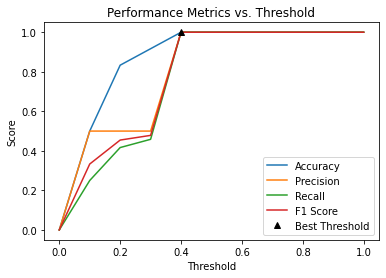

Optimal threshold: 0.4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [17]:
# Plot grafik kurva performa pada berbagai nilai threshold
import matplotlib.pyplot as plt

# Contoh: Pilih nilai threshold dengan akurasi tertinggi
optimal_threshold = thresholds[np.argmax(accuracy_scores)]

# Cari indeks nilai threshold pada array numpy
index = np.where(thresholds == optimal_threshold)[0][0]

# Ambil nilai akurasi, presisi, recall, dan F1 score pada indeks yang sesuai
accuracy = accuracy_scores[index]
precision = precision_scores[index]
recall = recall_scores[index]
f1_score = f1_scores[index]

plt.plot(thresholds, accuracy_scores, label="Accuracy")
plt.plot(thresholds, precision_scores, label="Precision")
plt.plot(thresholds, recall_scores, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.plot(optimal_threshold,accuracy,'k^', label='Best Threshold') 
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs. Threshold")
plt.show()

print("Optimal threshold:", optimal_threshold)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

# Evaluasi Anti Spoofing

In [1]:
import os
import glob

test_data_dir = "validasi_spoofing" # ganti dengan path ke direktori test data
test_data = []

for subdir in os.listdir(test_data_dir):
    subdir_path = os.path.join(test_data_dir, subdir)
    if os.path.isdir(subdir_path):
        for image_path in glob.glob(os.path.join(subdir_path, "*.jpg")):
            label = subdir
            test_data.append((image_path, label))


In [2]:
test_data

[('validasi_spoofing\\Fake\\a 1.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 10.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 11.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 12.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 13.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 14.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 15.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 16.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 17.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 18.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 19.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 2.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 20.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 21.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 22.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 23.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 24.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 25.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 26.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 27.jpg', 'Fake'),
 ('validasi_spoofing\\Fake\\a 28.jpg', 'Fa

In [3]:
from keras.models import load_model

# load model
model_anti_spoofing = load_model('model_spoofing_1.h5')

In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array



def get_anti_spoofing(frame, model,threshold):
    
    faces = face_cascade.detectMultiScale(frame, 1.1, 4)
    # Jika tidak ada wajah yang terdeteksi, kembalikan None
    # If no face is detected, return None
    if len(faces)>0:
        x1, y1, width, height = faces[0]
    else:
        return None

    # Extract face region
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = frame[y1:y2, x1:x2]
    
    # Konversi wajah menjadi array numpy
    img = array_to_img(face, scale=False)
    img = img.resize((323, 323))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Preprocessing gambar
    x /= 255.0

    # Prediksi kelas gambar
    pred = model.predict(x)
    score = pred[0].tolist()
    
    if score[0] < threshold:
        label = 'Fake'
    else:
        label = 'Real'

    return label

## Threshold Tuning

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# list of possible thresholds
thresholds = np.arange(0, 1.1, 0.1)

# initialize variables to store the best threshold and accuracy
best_threshold = 0
best_accuracy = 0

list_thresh = []
list_acc = []

# Buat daftar kosong untuk menyimpan skor performa pada setiap nilai threshold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# loop through each threshold
for threshold in thresholds:
    # initialize variables to store the true and predicted labels
    y_true = []
    y_pred = []

    # loop through each test image
    for images, label in test_data:
        image = cv2.imread(images)
        # get the predicted label and score for the image
        # Extract embedding from image and append to list
        label_pred = get_anti_spoofing(image, model_anti_spoofing, threshold)

        # Check if embedding is None
        if label_pred is None:
            continue

        # add the true and predicted labels to the respective lists
        y_true.append(label)
        y_pred.append(label_pred)

    # calculate the accuracy score for this threshold
    accuracy = accuracy_score(y_true, y_pred)
    
    list_thresh.append(threshold)
    list_acc.append(accuracy)
    
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    recall_scores.append(recall_score(y_true, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, average='macro', zero_division=0))

    # update the best threshold and accuracy if the current accuracy is higher
    if accuracy > best_accuracy:
        best_threshold = threshold
        best_accuracy = accuracy

# print the best threshold and accuracy
print("Best threshold:", best_threshold)
print("Best accuracy:", best_accuracy)
print()
print('Threshold')
print(list_thresh)
print('Accuracy')
print(list_acc)
print()
print('Label Benar')
print(y_true)
print('Label Prediksi')
print(y_pred)

1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 305ms/step
Best threshold: 0.8
Best accuracy: 0.8863636363636364

Threshold
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
Accuracy
[0.3409090909090909, 0.3409090909090909, 0.4772727272727273, 0.5, 0.5909090909090909, 0.6590909090909091, 0.7727272727272727, 0.8636363636363636, 0.8863636363636364, 0.7727272727272727, 0.6590909090909091]

Label Benar
['Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real', 'Real']
Label Prediksi
['Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake', 'Fake',

In [25]:
'''import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# list of possible thresholds
thresholds = [0.8]

# initialize variables to store the best threshold and accuracy
best_threshold = 0
best_accuracy = 0

list_thresh = []
list_acc = []

# Buat daftar kosong untuk menyimpan skor performa pada setiap nilai threshold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# loop through each threshold
for threshold in thresholds:
    # initialize variables to store the true and predicted labels
    y_true = []
    y_pred = []

    # loop through each test image
    for images, label in test_data:
        image = cv2.imread(images)
        # get the predicted label and score for the image
        # Extract embedding from image and append to list
        label_pred = get_anti_spoofing(image, model_anti_spoofing, threshold)

        # Check if embedding is None
        if label_pred is None:
            continue

        # add the true and predicted labels to the respective lists
        y_true.append(label)
        y_pred.append(label_pred)

    # calculate the accuracy score for this threshold
    accuracy = accuracy_score(y_true, y_pred)
    
    list_thresh.append(threshold)
    list_acc.append(accuracy)
    
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    recall_scores.append(recall_score(y_true, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, average='macro', zero_division=0))

    # update the best threshold and accuracy if the current accuracy is higher
    if accuracy > best_accuracy:
        best_threshold = threshold
        best_accuracy = accuracy

# print the best threshold and accuracy
print("Best threshold:", best_threshold)
print("Best accuracy:", best_accuracy)
print()
print('Threshold')
print(list_thresh)
print('Accuracy')
print(list_acc)
print()
print('Label Benar')
print(y_true)
print('Label Prediksi')
print(y_pred)'''

'import numpy as np\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\n# list of possible thresholds\nthresholds = [0.8]\n\n# initialize variables to store the best threshold and accuracy\nbest_threshold = 0\nbest_accuracy = 0\n\nlist_thresh = []\nlist_acc = []\n\n# Buat daftar kosong untuk menyimpan skor performa pada setiap nilai threshold\naccuracy_scores = []\nprecision_scores = []\nrecall_scores = []\nf1_scores = []\n\n# loop through each threshold\nfor threshold in thresholds:\n    # initialize variables to store the true and predicted labels\n    y_true = []\n    y_pred = []\n\n    # loop through each test image\n    for images, label in test_data:\n        image = cv2.imread(images)\n        # get the predicted label and score for the image\n        # Extract embedding from image and append to list\n        label_pred = get_anti_spoofing(image, model_anti_spoofing, threshold)\n\n        # Check if embedding is None\n        if label_pred is 

## Accuracy, Precision, Recall & F1 score

In [26]:
# Cetak skor performa pada setiap nilai threshold
print("Accuracy scores:", accuracy_scores)
print("Precision scores:", precision_scores)
print("Recall scores:", recall_scores)
print("F1 scores:", f1_scores)

Accuracy scores: [0.3409090909090909, 0.3409090909090909, 0.4772727272727273, 0.5, 0.5909090909090909, 0.6590909090909091, 0.7727272727272727, 0.8636363636363636, 0.8863636363636364, 0.7727272727272727, 0.6590909090909091]
Precision scores: [0.17045454545454544, 0.17045454545454544, 0.6973684210526316, 0.7027027027027027, 0.7272727272727273, 0.75, 0.8, 0.848421052631579, 0.8696581196581197, 0.7575757575757576, 0.32954545454545453]
Recall scores: [0.5, 0.5, 0.603448275862069, 0.6206896551724138, 0.6896551724137931, 0.7413793103448276, 0.8275862068965517, 0.8804597701149426, 0.8977011494252873, 0.7149425287356321, 0.5]
F1 scores: [0.2542372881355932, 0.2542372881355932, 0.4544474393530997, 0.48290598290598286, 0.5874999999999999, 0.6589147286821706, 0.7708333333333333, 0.8562091503267975, 0.8787878787878788, 0.7270471464019851, 0.3972602739726027]


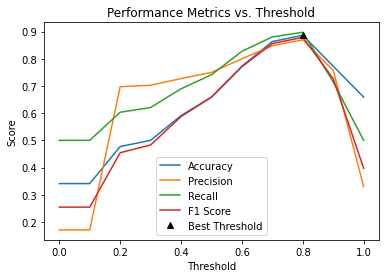

Optimal threshold: 0.8
Accuracy: 0.8863636363636364
Precision: 0.8696581196581197
Recall: 0.8977011494252873
F1 Score: 0.8787878787878788


In [28]:
# Plot grafik kurva performa pada berbagai nilai threshold
import matplotlib.pyplot as plt

# Contoh: Pilih nilai threshold dengan akurasi tertinggi
optimal_threshold = thresholds[np.argmax(accuracy_scores)]

# Cari indeks nilai threshold pada array numpy
index = np.where(thresholds == optimal_threshold)[0][0]

# Ambil nilai akurasi, presisi, recall, dan F1 score pada indeks yang sesuai
accuracy = accuracy_scores[index]
precision = precision_scores[index]
recall = recall_scores[index]
f1_score = f1_scores[index]

plt.plot(thresholds, accuracy_scores, label="Accuracy")
plt.plot(thresholds, precision_scores, label="Precision")
plt.plot(thresholds, recall_scores, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.plot(optimal_threshold,accuracy,'k^', label='Best Threshold') 
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs. Threshold")
plt.show()

print("Optimal threshold:", optimal_threshold)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

## ROC Curve

label true:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
label false:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


C:\Users\andha\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


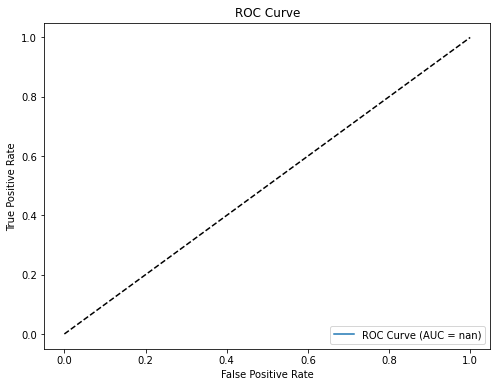

AUC: nan


In [252]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Inisialisasi objek LabelEncoder
y_true_encoded = [1 if true == 'andhar' else 0 for true in y_true]
y_pred_encoded = [1 if pred == 'andhar' else 0 for pred in y_pred]

print('label true: ',y_true_encoded)
print('label false: ',y_pred_encoded)

if accuracy == 1:
    print('ROC tidak dibutuhkan karena accuracy', accuracy*100,'%')
else:

    # Menghitung nilai fpr, tpr, dan thresholds
    fpr, tpr, thresholds = roc_curve(y_true_encoded, y_pred_encoded)

    # Menghitung nilai AUC
    roc_auc = auc(fpr, tpr)

    # Membuat plot ROC
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="{} (AUC = {:.2f})".format("ROC Curve", roc_auc))

    # Mengatur parameter plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # Menampilkan plot
    plt.show()

    # Menampilkan hasil
    print("AUC: {:.2f}".format(roc_auc))



In [253]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score

# Load face detection model
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load anti-spoofing model
model = load_model('model_anti_spoofings.h5')

# Path to validation dataset folder
valid_dir = 'validasi_spoofing'

# List of validation images
valid_images = os.listdir(valid_dir)

# True labels for validation images (0 for real, 1 for fake)
true_labels = [0 if 'real' in image else 1 for image in valid_images]

# List of predicted labels
predicted_labels = []

# Threshold values to try
thresholds = np.arange(0.05, 1.0, 0.05)

# Loop through validation images
probas = []
for image_file in valid_images:
    # Load image
    img_path = os.path.join(valid_dir, image_file)
    img = cv2.imread(img_path)

    # Detect faces
    faces = face_cascade.detectMultiScale(img, 1.1, 4)

    # If no face is detected, skip the image
    if len(faces) == 0:
        continue

    # Extract face region
    x1, y1, width, height = faces[0]
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]

    # Resize face to 224x224
    img = cv2.resize(face, (224, 224))

    # Convert image to array and preprocess
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    # Predict class probabilities
    proba = model.predict(x)
    probas.append(proba[0][0])

# Find best threshold
best_accuracy = 0
best_threshold = 0
accuracies = []
for threshold in thresholds:
    predicted_labels_thresholded = [0 if proba < threshold else 1 for proba in probas]
    accuracy = accuracy_score(true_labels, predicted_labels_thresholded)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# Print best threshold and accuracy
print(f'Best threshold: {best_threshold:.4f}')
print(f'Best accuracy: {best_accuracy:.4f}')


ValueError: Found input variables with inconsistent numbers of samples: [2, 0]